In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/USA_Housing.csv


# Import Necessary Libraries for analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
df = pd.read_csv('/kaggle/input/USA_Housing.csv')
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


## Data Preprocessing  

**Remove unnecessary columns/features**

In [10]:
# drop 'Address' since it is of no interest to regression analysis
df.drop(columns=['Address'], inplace=True)

# change column/features names for easier manipulation and access
df.rename(columns={'Avg. Area Income':'Income', 
                   'Avg. Area House Age':'House Age', 
                   'Avg. Area Number of Rooms': 'Avg Room_area', 
                   'Avg. Area Number of Bedrooms':'Avg Bedroom_area'}, inplace=True)
df.head(2)

,Income,House Age,Avg Room_area,Avg Bedroom_area,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06


### Data Exploration

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
Income              5000 non-null float64
House Age           5000 non-null float64
Avg Room_area       5000 non-null float64
Avg Bedroom_area    5000 non-null float64
Area Population     5000 non-null float64
Price               5000 non-null float64
dtypes: float64(6)
memory usage: 234.5 KB


In [12]:
# see correlation of features to the target variable 'Price'
df.corr()['Price'].sort_values()

Avg Bedroom_area    0.171071
Avg Room_area       0.335664
Area Population     0.408556
House Age           0.452543
Income              0.639734
Price               1.000000
Name: Price, dtype: float64

**There is positive correlation between features and target variable**

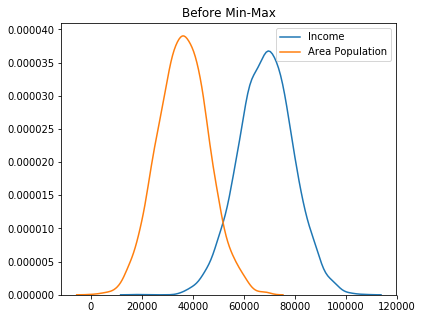

In [13]:
# assessing to see if normalization is necessary
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.set_title('Before Min-Max')
sns.kdeplot(df['Income'], ax=ax1)
sns.kdeplot(df['Area Population'], ax=ax1)
plt.show()

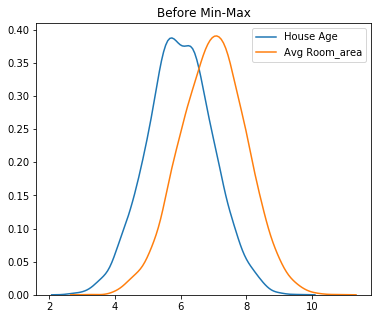

In [14]:
fig, ax2 = plt.subplots(figsize=(6,5))
ax2.set_title('Before Min-Max')
sns.kdeplot(df['House Age'], ax=ax2)
sns.kdeplot(df['Avg Room_area'], ax=ax2)
plt.show()

### Frome the above analysis, it is evident that normalization would be beneificial to our model

In [15]:
# normalize x_data using the min max method
X = df[['Income', 'House Age', 'Avg Room_area', 'Avg Bedroom_area', 'Area Population']]
Y  = df['Price']

for x in X:
    df[x] = (df[x] - min(df[x])) / (max(df[x]) - min(df[x]))
df.head(3)

,Income,House Age,Avg Room_area,Avg Bedroom_area,Area Population,Price
0,0.686822,0.441986,0.501502,0.464444,0.329942,1.059034e+06
1,0.683521,0.488538,0.464501,0.242222,0.575968,1.505891e+06
2,0.483737,0.468609,0.701350,0.695556,0.528582,1.058988e+06


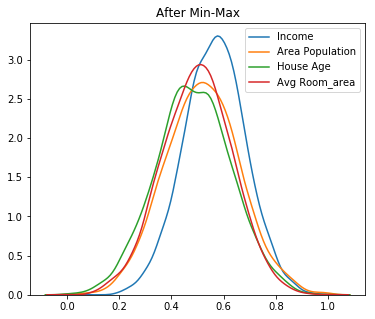

In [16]:
# visualise the effect of normalization
fig, ax3 = plt.subplots(figsize=(6,5))
ax3.set_title('After Min-Max')
sns.kdeplot(df['Income'], ax=ax3)
sns.kdeplot(df['Area Population'], ax=ax3)
sns.kdeplot(df['House Age'], ax=ax3)
sns.kdeplot(df['Avg Room_area'], ax=ax3)
plt.show()

# Identify if a linear relationship exists

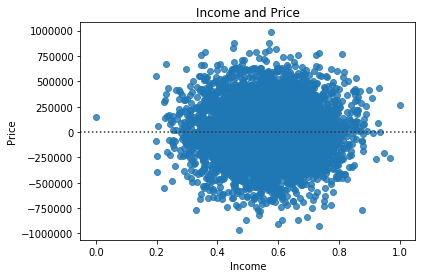

In [17]:
# using seaborn residual plot too identify relationship
sns.residplot(df['Income'], df['Price'])
plt.title('Income and Price')
plt.show()

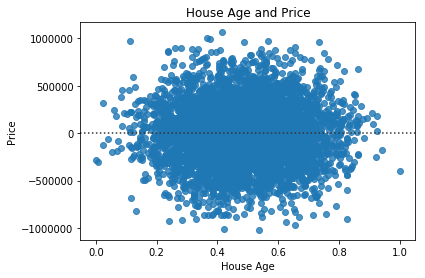

In [18]:
sns.residplot(df['House Age'], df['Price'])
plt.title('House Age and Price')
plt.show()

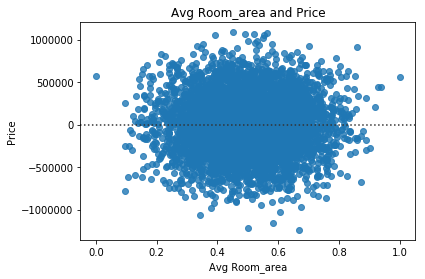

In [19]:
sns.residplot(df['Avg Room_area'], df['Price'])
plt.title('Avg Room_area and Price')
plt.show()

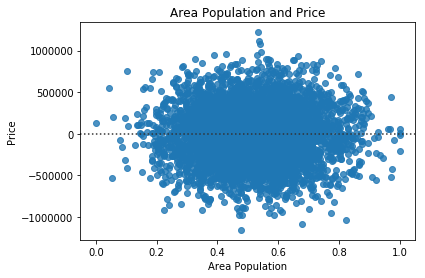

In [20]:
sns.residplot(df['Area Population'], df['Price'])
plt.title('Area Population and Price')
plt.show()

### By the above analysis, the residual plot indicates that the data points are randomly spread about the x-axis meaning that a linear relationship exists.  

**There is also positively correlation between independent variables and Price**

# Building the model

In [21]:
# training and testing data
x_data = df[['Income', 'House Age', 'Avg Room_area', 'Area Population']].values
y_data  = df['Price'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4250, 5) (750, 5) (4250,) (750,)


In [22]:
# linear model object
lm = LinearRegression()

# fit the model
lm.fit(x_train, y_train)

# estimate 
yhat = lm.predict(x_test)

In [23]:
# dataframe of testing y values and predicted values
df_new = pd.DataFrame({'Actual': y_test, 'Predicted': yhat})
df_new.head()

,Actual,Predicted
398,894251.068636,972760.373418
3833,932979.360621,956215.072659
4836,920747.911288,908812.346945
4572,691854.921027,496109.959483
636,732733.236293,719354.481586


In [26]:
# use metrics to determine the fit of the model
# r-squared 
R2 = r2_score(y_test, yhat)
print('R2 score: ', R2)

R2 score:  0.9180598405085169


**Around 91.816% in the variance in Price is explained by the Linear Model, indicating that our model has performed well!**